In [1]:
import numpy as np
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

[[100.         100.         100.         ... 100.         100.
  100.        ]
 [100.          99.70044955  99.70044955 ...  99.70044955  99.70044955
    0.        ]
 [100.          99.70044955  99.70044955 ...  99.70044955  99.70044955
    0.        ]
 ...
 [100.          99.70044955  99.70044955 ...   0.           0.
    0.        ]
 [100.          99.70044955  99.70044955 ...   0.           0.
    0.        ]
 [100.           0.           0.         ...   0.           0.
    0.        ]]


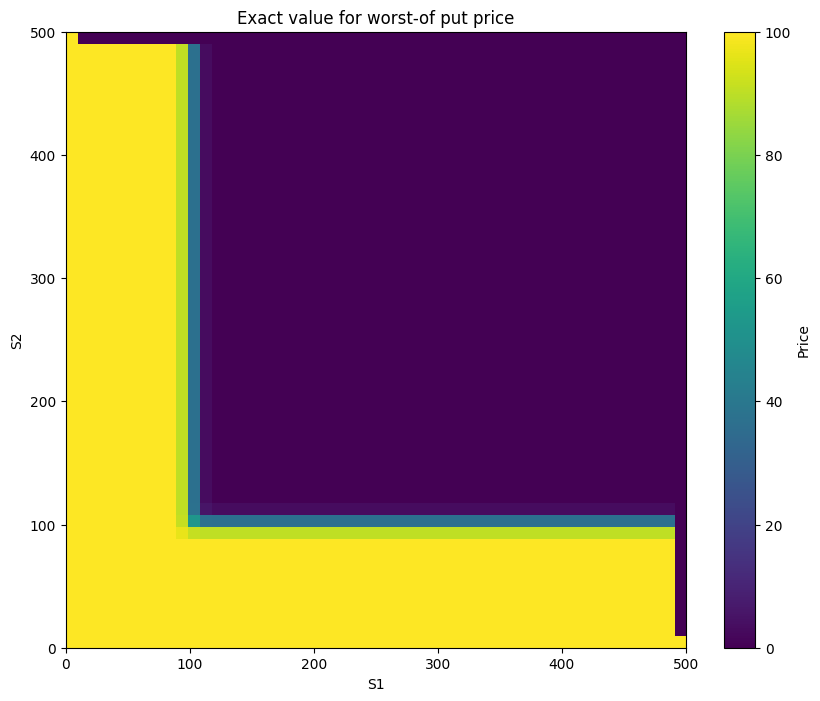

In [2]:
# Compute exact solution for the case of worst-off put

def worst_of_exact(sigV, sigH, rho, r, V, H, F, tau):
    """
    Compute the exact solution for the Worst-Off Put Option using the given parameters.

    Parameters:
    sigV : float  -> Volatility of asset V
    sigH : float  -> Volatility of asset H
    rho  : float  -> Correlation between V and H
    r    : float  -> Risk-free interest rate
    V    : float  -> Initial price of asset V
    H    : float  -> Initial price of asset H
    F    : float  -> Strike price
    tau  : float  -> Time to maturity

    Returns:
    u_exact : float -> Exact price of the Worst-Off Put Option
    """

    # Compute gamma1 and gamma2
    gamma1 = (np.log(H / F) + (r - 0.5 * sigH**2) * tau) / (sigH * np.sqrt(tau))
    gamma2 = (np.log(V / F) + (r - 0.5 * sigV**2) * tau) / (sigV * np.sqrt(tau))

    # Combined volatility
    sig = np.sqrt(sigV**2 + sigH**2 - 2 * rho * sigV * sigH)
    rho_c = (rho * sigV - sigH) / sig
    rho_C = (rho * sigH - sigV) / sig

    # Compute alpha1, alpha2, beta1, beta2
    alpha1 = gamma1 + sigH * np.sqrt(tau)
    alpha2 = (np.log(V / H) - 0.5 * sig**2 * np.sqrt(tau)) / (sig * np.sqrt(tau))

    beta1 = gamma2 + sigV * np.sqrt(tau)
    beta2 = (np.log(H / V) - 0.5 * sig**2 * np.sqrt(tau)) / (sig * np.sqrt(tau))

    # Compute the cumulative bivariate normal distribution values
    mvn_rho_c = multivariate_normal(mean=[0, 0], cov=[[1, rho_c], [rho_c, 1]])
    mvn_rho_C = multivariate_normal(mean=[0, 0], cov=[[1, rho_C], [rho_C, 1]])
    mvn_rho = multivariate_normal(mean=[0, 0], cov=[[1, rho], [rho, 1]])

    M0_H = H * mvn_rho_c.cdf([alpha1, alpha2])
    M0_V = V * mvn_rho_C.cdf([beta1, beta2])
    M0 = M0_H + M0_V  # Since F=0, last subterm is zero

    M1_H = H * mvn_rho_c.cdf([alpha1, alpha2])
    M1_V = V * mvn_rho_C.cdf([beta1, beta2])

    # Last term: -F * exp(-r * tau) * N2(gamma1, gamma2; rho)
    last_term = F * np.exp(-r * tau) * mvn_rho.cdf([gamma1, gamma2])

    M1 = M1_H + M1_V - last_term

    # Compute the Worst-Off Put Option Price
    u_exact = np.exp(-r * tau) * F - M0 + M1

    return u_exact

# Parameters
K = 100
S1_max, S2_max = 500, 500  # Maximum asset prices
S1_min, S2_min = 0, 0      # Minimum asset prices
m1, m2 = 50, 50          # Grid divisions
T = 0.1                    # Time to maturity
r = 0.03                   # Risk-free rate
rho = 0.5                  # Correlation
sigma1, sigma2 = 0.2, 0.2  # Volatilities
theta = 0.5                # MCS scheme parameter
num_steps = 2*m1           # Number of time steps

# Prepation for computing U_exact and plotting
resolution = 50
x = np.linspace(S1_min, S1_max, resolution)
y = np.linspace(S2_min, S2_max, resolution)
S1, S2 = np.meshgrid(x, y)

# Computing U_exact
U_exact = np.zeros((m1+1, m2+1))
for i in range (1, m1):
  for j in range (1, m2):
    if not (i == m1 and j == m2):
      U_exact[i, j] = worst_of_exact(sigma1, sigma2, rho, r, S1[i, j], S2[i, j], K, T)
U_exact[:, 0] = K
U_exact[0, :] = K
U_exact[-1, -1] = 0
print(U_exact)

# Plotting
plt.figure(figsize=(10, 8))
plt.imshow(U_exact, extent=[S1_min, S1_max, S2_min, S2_max], origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label= "Price")
plt.xlabel("S1")
plt.ylabel("S2")
plt.title("Exact value for worst-of put price")
plt.show()

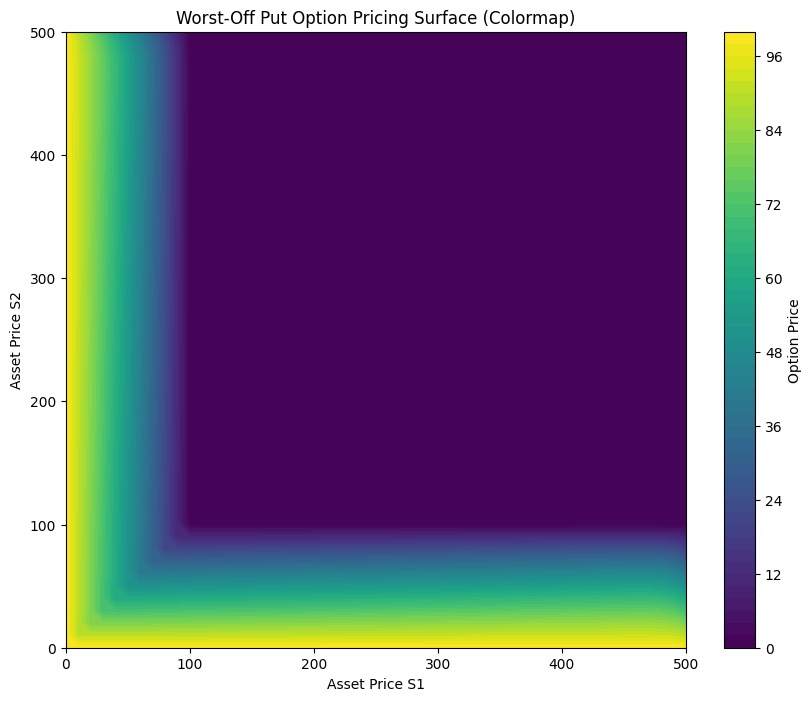

Total residual error:  1486.595105415618
Average residual error:  0.5715475222666736


In [3]:
# Uniform grid generation
def make_uniform_grid(m1, S1_max, m2, S2_max):
    Vec_s1 = np.linspace(0, S1_max, m1 + 1)  # Uniformly spaced grid for S1
    Vec_s2 = np.linspace(0, S2_max, m2 + 1)  # Uniformly spaced grid for S2
    Delta_s1 = Vec_s1[1] - Vec_s1[0]         # Uniform step size in S1 direction
    Delta_s2 = Vec_s2[1] - Vec_s2[0]         # Uniform step size in S2 direction
    return Vec_s1, Delta_s1, Vec_s2, Delta_s2

# Initialize payoff for worst-off put
def initialize_worst_off_put(m1, m2, Vec_s1, Vec_s2, K):
    payoff = np.zeros((m2 + 1, m1 + 1))
    for j in range(m2 + 1):
        for i in range(m1 + 1):
            payoff[j, i] = max(K - min(Vec_s1[i], Vec_s2[j]), 0)
    return payoff

# Apply dynamic boundary conditions at each time step
def apply_boundary_conditions(U, m1, m2, K):
    U[0, :] = K         # S2 = 0, payoff = K
    U[:, 0] = K         # S1 = 0, payoff = K
    U[-1, -1] = 0        # S1 -> infinity  S2 -> infinity, payoff = 0
    return U

# Create matrices A0, A1, A2 for finite difference scheme
def make_matrices(m1, m2, m, rho, sigma1, sigma2, r1, r2, Vec_s1, Vec_s2, Delta_s1, Delta_s2):
    A = np.zeros((m, m))
    A_0 = np.eye(m) # Here m is m1*m2
    A_1 = np.eye(m)
    A_2 = np.eye(m)

    # A0: Cross-derivative term
    for j in range(1, m2):
        for i in range(1, m1):
            # To leave the boundary unchange w.r.t. time (apply the bounadry condition),
            # we need to leave the rows corresponding to the boundary as identity
            if i != 0 and j !=0 and not (i == m1 and j == m2):
              idx = i + j * (m1 + 1)
              c = rho * sigma1 * sigma2 * Vec_s1[i] * Vec_s2[j] / (Delta_s1 * Delta_s2)
              A_0[idx, idx] += c
              A[idx, idx] += c
    A_0 = csc_matrix(A_0)

    # A1: S1 direction
    for j in range(m2 + 1):
        for i in range(1, m1):
           # To leave the boundary unchange w.r.t. time (apply the bounadry condition),
            # we need to adjust the rows corresponding to the boundary as identity
            if i != 0 and j !=0 and not (i == m1 and j == m2):
              idx = i + j * (m1 + 1)
              a = 0.5 * sigma1**2 * Vec_s1[i]**2 / Delta_s1**2
              b = r1 * Vec_s1[i] / Delta_s1
              A_1[idx, idx] += -r1 - 2 * a
              A_1[idx, idx - 1] += a - b
              A_1[idx, idx + 1] += a + b
              A[idx, idx] += -r1 - 2 * a
              A[idx, idx - 1] += a - b
              A[idx, idx + 1] += a + b
    A_1 = csc_matrix(A_1)

    # A2: S2 direction
    for j in range(1, m2):
        for i in range(m1 + 1):
          # To leave the boundary unchange w.r.t. time (apply the bounadry condition),
            # we need to adjust the rows corresponding to the boundary as identity
            if i != 0 and j !=0 and not (i == m1 and j == m2):
              idx = i + j * (m1 + 1)
              a = 0.5 * sigma2**2 * Vec_s2[j]**2 / Delta_s2**2
              b = r2 * Vec_s2[j] / Delta_s2
              A_2[idx, idx] += -r2 - 2 * a
              A_2[idx, idx - (m1 + 1)] += a - b
              A_2[idx, idx + (m1 + 1)] += a + b
              A[idx, idx] += -r2 - 2 * a
              A[idx, idx - (m1 + 1)] += a - b
              A[idx, idx + (m1 + 1)] += a + b
    A_2 = csc_matrix(A_2)
    A = csc_matrix(A)

    return A_0, A_1, A_2, A

# MCS Scheme for 2D Black-Scholes Equation
def MCS_scheme(m1, m2, Vec_s1, Vec_s2, K, T, r1, r2, rho, sigma1, sigma2, theta, num_steps):
    m = (m1 + 1) * (m2 + 1)
    Delta_s1 = Vec_s1[1] - Vec_s1[0]
    Delta_s2 = Vec_s2[1] - Vec_s2[0]
    delta_t = T / num_steps

    # Create matrices
    A_0, A_1, A_2, A = make_matrices(m1, m2, m, rho, sigma1, sigma2, r1, r2, Vec_s1, Vec_s2, Delta_s1, Delta_s2)

    # Initialize payoff
    U = initialize_worst_off_put(m1, m2, Vec_s1, Vec_s2, K)
    U= apply_boundary_conditions(U, m1, m2, K)
    U = U.reshape((m2 + 1, m1 + 1))

    # Time stepping
    I = csc_matrix(np.eye(m))
    lhs_1 = csc_matrix(I - theta * delta_t * A_1)
    lhs_2 = csc_matrix(I - theta * delta_t * A_2)

    for n in range(num_steps):
        # Reshape to 1D for matrix operations
        U_flat = U.flatten()

        # Step 1: Explicit update
        Y_0 = U_flat + delta_t * A.dot(U_flat)

        # Step 2: Implicit in S1 direction
        Y_1 = spsolve(lhs_1, Y_0 - theta*delta_t*A_1.dot(U_flat))

        # Step 3: Implicit in S2 direction
        Y_2 = spsolve(lhs_2, Y_1-theta*delta_t*A_2.dot(U_flat))

        # Step 4: Cross-derivative correction
        Y_0_hat = Y_0 + theta * delta_t * A.dot(Y_2 - U_flat)

        # Step 5: Y_0 tilta
        Y_0_tilta = Y_0_hat + (0.5 - theta)*delta_t*A.dot(Y_2 - U_flat)

        # Step 6: Y_1 tilta
        Y_1_tilta = spsolve(I, Y_0_tilta + theta*delta_t*A_1.dot(Y_1 - U_flat))

        # Step 7: Y_2 tilta
        Y_2_tilta = spsolve(I, Y_1_tilta + theta*delta_t*A_2.dot(Y_2 - U_flat))

        # Update U
        U = Y_2_tilta.reshape((m2 + 1, m1 + 1))
    return U

# Parameters
K = 100
S1_max, S2_max = 500, 500  # Maximum asset prices
m1, m2 = 50, 50          # Grid divisions
T = 0.03                    # Time to maturity
r1, r2 = 0.03, 0.03        # Risk-free rates
rho = 0.5                  # Correlation
sigma1, sigma2 = 0.2, 0.2  # Volatilities
theta = 0.5                # MCS scheme parameter
num_steps = 2*m1           # Number of time steps

# Generate grid
Vec_s1, Delta_s1, Vec_s2, Delta_s2 = make_uniform_grid(m1, S1_max, m2, S2_max)

# Solve the PDE using MCS scheme
U = MCS_scheme(m1, m2, Vec_s1, Vec_s2, K, T, r1, r2, rho, sigma1, sigma2, theta, num_steps)


S1, S2 = np.meshgrid(Vec_s1, Vec_s2)
plt.figure(figsize=(10, 8))
plt.contourf(S1, S2, U, cmap='viridis', levels=50)
plt.colorbar(label='Option Price')
plt.title('Worst-Off Put Option Pricing Surface (Colormap)')
plt.xlabel('Asset Price S1')
plt.ylabel('Asset Price S2')
plt.xlim([Vec_s1.min(), Vec_s1.max()])
plt.ylim([Vec_s2.min(), Vec_s2.max()])
plt.show()

# Compute residual error, represented as the Forbenius norm of U - U_exact (Mean-square error)
print("Total residual error: ", np.linalg.norm(U - U_exact))
print("Average residual error: ", np.linalg.norm((U - U_exact)/(51*51)))

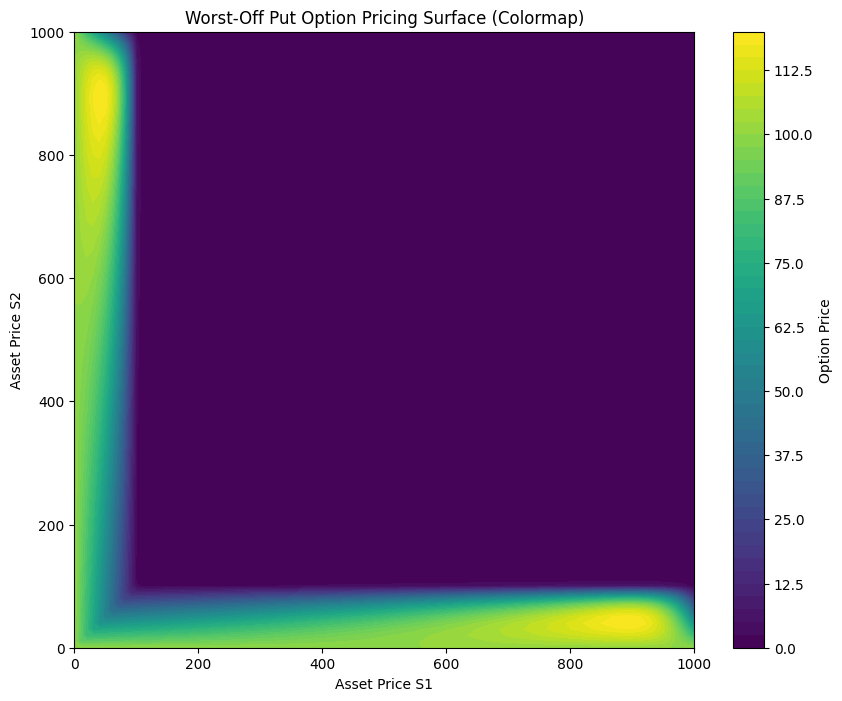

[[100.         100.         100.         ... 100.         100.
  100.        ]
 [100.          99.91004049  99.91004049 ...  99.91004049  99.91004049
    0.        ]
 [100.          99.91004049  99.91004049 ...  99.91004049  99.91004049
    0.        ]
 ...
 [100.          99.91004049  99.91004049 ...   0.           0.
    0.        ]
 [100.          99.91004049  99.91004049 ...   0.           0.
    0.        ]
 [100.           0.           0.         ...   0.           0.
    0.        ]]
Total residual error:  1384.1544413138615
Average residual error:  0.5321624149611156


In [4]:
# Experiment 1: rerun the code on a larger domain

# Parameters
K = 100
S1_max, S2_max = 1000, 1000   # Maximum asset prices
m1, m2 = 100, 100           # Grid divisions
T = 0.1                     # Time to maturity
r1, r2 = 0.03, 0.03         # Risk-free rates
rho = 0.5                   # Correlation
sigma1, sigma2 = 0.2, 0.2   # Volatilities
theta = 0.5                 # MCS scheme parameter
num_steps = 2*m1            # Number of time steps

# Generate grid
Vec_s1, Delta_s1, Vec_s2, Delta_s2 = make_uniform_grid(m1, S1_max, m2, S2_max)

# Solve the PDE using MCS scheme
U = MCS_scheme(m1, m2, Vec_s1, Vec_s2, K, T, r1, r2, rho, sigma1, sigma2, theta, num_steps)

# Plot the result
S1, S2 = np.meshgrid(Vec_s1, Vec_s2)
plt.figure(figsize=(10, 8))
plt.contourf(S1, S2, U, cmap='viridis', levels=50)
plt.colorbar(label='Option Price')
plt.title('Worst-Off Put Option Pricing Surface (Colormap)')
plt.xlabel('Asset Price S1')
plt.ylabel('Asset Price S2')
plt.xlim([Vec_s1.min(), Vec_s1.max()])
plt.ylim([Vec_s2.min(), Vec_s2.max()])
plt.show()

# Parameters for exact solutions
K = 100
S1_max, S2_max = 500, 500  # Maximum asset prices
S1_min, S2_min = 0, 0      # Minimum asset prices
m1, m2 = 50, 50          # Grid divisions
T = 0.03                   # Time to maturity
r = 0.03                   # Risk-free rate
rho = 0.5                  # Correlation
sigma1, sigma2 = 0.2, 0.2  # Volatilities
num_steps = 2*m1           # Number of time steps

# Computing U_exact
U_exact = np.zeros((m1+1, m2+1))
for i in range (1, m1):
  for j in range (1, m2):
    if not (i == m1 and j == m2):
      U_exact[i, j] = worst_of_exact(sigma1, sigma2, rho, r, S1[i, j], S2[i, j], K, T)
U_exact[:, 0] = K
U_exact[0, :] = K
U_exact[-1, -1] = 0
print(U_exact)

# Compute residual error, represented as the Forbenius norm of U - U_exact (Mean-square error)
print("Total residual error: ", np.linalg.norm(U[:51,:51] - U_exact))
print("Average residual error: ", np.linalg.norm((U[:51,:51] - U_exact)/(51*51)))

Comment: enlarging the domain while leaving delta_t and delta_x unchanged will decrease the average residual error

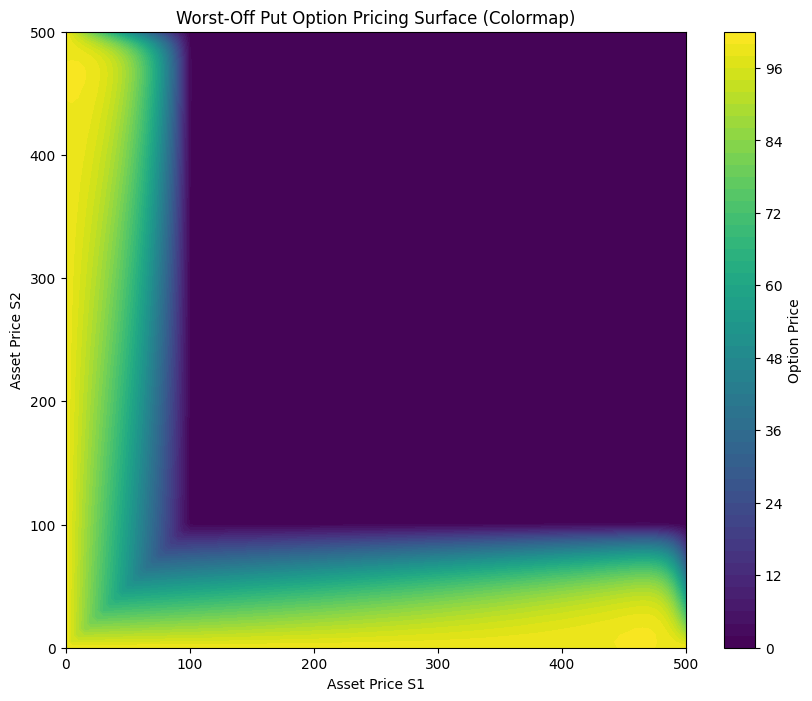

Total residual error:  2626.324791580181
Average residual error:  0.2574575817645507


In [5]:
# Experiment 2: Now, rerun the code for small domain on a refined mesh

# Parameters
K = 100
S1_max, S2_max = 500, 500  # Maximum asset prices
m1, m2 = 100, 100            # Grid divisions
T = 0.03                    # Time to maturity
r1, r2 = 0.03, 0.03        # Risk-free rates
rho = 0.5                  # Correlation
sigma1, sigma2 = 0.2, 0.2  # Volatilities
theta = 0.5                # MCS scheme parameter
num_steps = 2*m1           # Number of time steps

# Generate grid
Vec_s1, Delta_s1, Vec_s2, Delta_s2 = make_uniform_grid(m1, S1_max, m2, S2_max)

# Solve the PDE using MCS scheme
U = MCS_scheme(m1, m2, Vec_s1, Vec_s2, K, T, r1, r2, rho, sigma1, sigma2, theta, num_steps)

# Plot the result
S1, S2 = np.meshgrid(Vec_s1, Vec_s2)
plt.figure(figsize=(10, 8))
plt.contourf(S1, S2, U, cmap='viridis', levels=50)
plt.colorbar(label='Option Price')
plt.title('Worst-Off Put Option Pricing Surface (Colormap)')
plt.xlabel('Asset Price S1')
plt.ylabel('Asset Price S2')
plt.xlim([Vec_s1.min(), Vec_s1.max()])
plt.ylim([Vec_s2.min(), Vec_s2.max()])
plt.show()

# Computing U_exact
U_exact = np.zeros((m1+1, m2+1))
for i in range (1, m1):
  for j in range (1, m2):
    if not (i == m1 and j == m2):
      U_exact[i, j] = worst_of_exact(sigma1, sigma2, rho, r1, S1[i, j], S2[i, j], K, T)
U_exact[:, 0] = K
U_exact[0, :] = K
U_exact[-1, -1] = 0

# Compute residual error, represented as the Forbenius norm of U - U_exact (Mean-square error)
print("Total residual error: ", np.linalg.norm(U - U_exact))
print("Average residual error: ", np.linalg.norm((U - U_exact)/(101*101)))

Comment: refining the mesh will sometimes reduce the error but not always if the domain remains unchanged because the more grids you take, the more it tends to blows up due to finite domain.For each domain size, there is an optimal delta x.

> Add blockquote

